In [90]:
import pandas as pd
import praw
from praw.models import MoreComments
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict
import spacy
import string

In [101]:
ci = "TTvdII1Rg7IzUg" # your client id
cs = "ZBH4sSqYdiRxZZR9h4IosSbAc1K8-Q" #your client secret
ua = "gibberish" #your user agent name
sub = "ireland" #the name of the subreddit (not including the 'r/')

In [102]:
# Scrape reddit for text content
reddit = praw.Reddit(
    client_id=ci,
    client_secret=cs,
    user_agent=ua
)





def scrape_year_data(reddit,limit=50): 
    
    title_dict = {"title": [],"time":[]}
    
    for post in reddit.subreddit(sub).top(time_filter='year', limit=limit): 
        if not post.stickied:
            title_dict["title"].append(post.title)
            title_dict["time"].append(int(post.created))
        
    return title_dict       
            

            #this line collects the post titles
            #f.write(post.title+"\n")

    #         #this line collects the post content
    #         f.write(post.selftext+"\n")

    #         #this section collects the comments
    #         for comment in post.comments:
    #             if isinstance(comment, MoreComments):
    #                 continue
    #             f.write(comment.body+"\n")



In [103]:
nlp = spacy.load('en')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sed\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [104]:
def remove_stops(text):
    """Function to remove most common stop words from text"""
    my_doc = nlp(text)

    # create list of token words
    token_list= [token.text for token in my_doc]

    # return list of word tokens after removing stopwords
    return [word for word in token_list if nlp.vocab[word].is_stop == False]

In [105]:
def preprocess_df(df):
    df['title_no_stops'] = df['title'].apply(lambda text:" ".join(remove_stops(text)))
    df["title_lemmatized"] = df['title_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
    

## Positivity of Countries

In [106]:
sentimentAnlyser = SentimentIntensityAnalyzer()

In [107]:
def average_sentiment(country):
    title_dict = {"title": []}
    
    for post in reddit.subreddit(country).top(limit=200): 
        if not post.stickied:
            title_dict["title"].append(post.title)
            
    sentimentAnlyser = SentimentIntensityAnalyzer()
    df = pd.DataFrame.from_dict(title_dict)
    df.to_csv(f'data/{country}.csv')
    #  Unccomment to clean the data files to remove stop words and lemmatize
    #preprocess_df(df)
    
    df['scores'] = df['title'].apply(lambda title: sentimentAnlyser.polarity_scores(title)['compound'])
    df['normalised_scores'] = df['scores'].apply(lambda score: (score+1)/2)
           
    return df['normalised_scores'].mean()  
    

In [112]:
countries = ['egypt','Norway','Switzerland','Netherlands','india','finland','yemen']

country_dict = dict()
for country in countries:
    country_dict[country] = average_sentiment(country)

In [113]:
country_dict

{'egypt': 0.550446,
 'Norway': 0.5792835,
 'Switzerland': 0.5698655,
 'Netherlands': 0.5650185000000001,
 'india': 0.51415025,
 'finland': 0.5832595,
 'yemen': 0.510160101010101}

In [117]:
country_dict ={k: v for k, v in sorted(country_dict.items(), key=lambda item: item[1])}

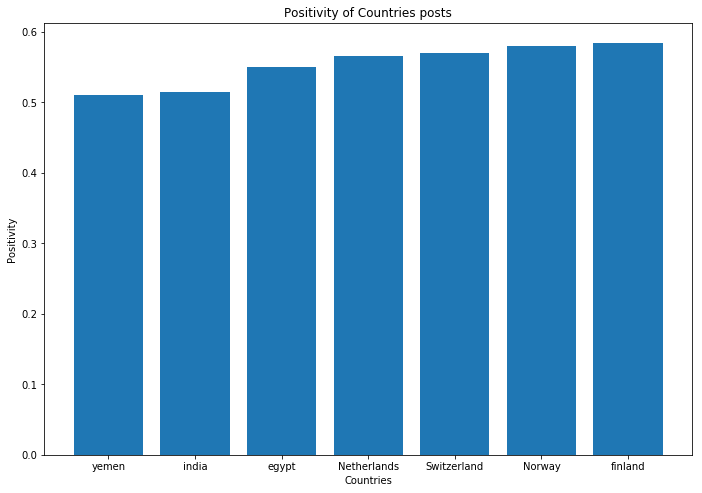

In [118]:
country = country_dict.keys()
positivity = country_dict.values()

fig = plt.figure(figsize=(9,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(country,positivity)
plt.title('Positivity of Countries posts')
plt.xlabel('Countries')
plt.ylabel('Positivity')
plt.show()

## Sentiment Analysis of Ireland

In [45]:
title_dict = scrape_year_data(reddit,1000)
df = pd.DataFrame.from_dict(title_dict)
df.to_csv(f'data/uncleaned_Ireland.csv')

df.sort_values(by='time',inplace=True)

#Week and date info
df['date_time']= pd.to_datetime(df['time'],unit='s').dt.date
df['weeks'] = pd.to_datetime(df['time'],unit='s') - pd.to_timedelta(7,unit= 'd')

df.drop_duplicates(subset=['date_time'],inplace=True)
df.head()

,title,time,date_time,weeks
507,Child labour.,1582591320,2020-02-25,2020-02-18 00:42:00
298,Very True,1582776603,2020-02-27,2020-02-20 04:10:03
721,Paddys day outfit sorted,1582899684,2020-02-28,2020-02-21 14:21:24
5,Landlords when they have to give back a deposit.,1582999918,2020-02-29,2020-02-22 18:11:58
836,Me celebrating St Patrick's Day alone this year,1583072175,2020-03-01,2020-02-23 14:16:15


In [84]:
df['weeks'] = pd.to_datetime(df['time'],unit='s')- pd.to_timedelta(7,unit= 'd')

In [85]:
df.normalised_scores.nunique()

113

(52, 2)

In [46]:
df['date_time']= pd.to_datetime(df['time'],unit='s').dt.date
df.drop_duplicates(subset=['date_time'],inplace=True)

In [74]:
df.head()

,title,time,date_time,weeks,scores,normalised_scores
507,Child labour.,1582591320,2020-02-25,2020-02-18 00:42:00,0.0000,0.50000
298,Very True,1582776603,2020-02-27,2020-02-20 04:10:03,0.4754,0.73770
721,Paddys day outfit sorted,1582899684,2020-02-28,2020-02-21 14:21:24,0.0000,0.50000
5,Landlords when they have to give back a deposit.,1582999918,2020-02-29,2020-02-22 18:11:58,0.0000,0.50000
836,Me celebrating St Patrick's Day alone this year,1583072175,2020-03-01,2020-02-23 14:16:15,0.4019,0.70095


In [48]:
df['scores'] = df['title'].apply(lambda title: sentimentAnlyser.polarity_scores(title)['compound'])

df.head(10)

,title,time,date_time,weeks,scores
507,Child labour.,1582591320,2020-02-25,2020-02-18 00:42:00,0.0000
298,Very True,1582776603,2020-02-27,2020-02-20 04:10:03,0.4754
721,Paddys day outfit sorted,1582899684,2020-02-28,2020-02-21 14:21:24,0.0000
5,Landlords when they have to give back a deposit.,1582999918,2020-02-29,2020-02-22 18:11:58,0.0000
836,Me celebrating St Patrick's Day alone this year,1583072175,2020-03-01,2020-02-23 14:16:15,0.4019
115,RIP Carlow,1583108544,2020-03-02,2020-02-24 00:22:24,0.0000
717,So A Woman Has Been Banned From Participating ...,1583213094,2020-03-03,2020-02-25 05:24:54,-0.6369
245,"How I, as a Pole see Ireland (P.S thanks for t...",1583293841,2020-03-04,2020-02-26 03:50:41,0.4404
226,Cliffs of Moher,1583425827,2020-03-05,2020-02-27 16:30:27,0.0000
212,Ireland's response,1583484824,2020-03-06,2020-02-28 08:53:44,0.0000


In [49]:
df['scores'].mean()

0.06726878453038675

In [50]:
df['scores'].max()

0.9169

In [51]:
df['scores'].min()

-0.8883

In [52]:
# Normalise the results
df['normalised_scores'] = df['scores'].apply(lambda score: (score+1)/2)
df.head(10)

,title,time,date_time,weeks,scores,normalised_scores
507,Child labour.,1582591320,2020-02-25,2020-02-18 00:42:00,0.0000,0.50000
298,Very True,1582776603,2020-02-27,2020-02-20 04:10:03,0.4754,0.73770
721,Paddys day outfit sorted,1582899684,2020-02-28,2020-02-21 14:21:24,0.0000,0.50000
5,Landlords when they have to give back a deposit.,1582999918,2020-02-29,2020-02-22 18:11:58,0.0000,0.50000
836,Me celebrating St Patrick's Day alone this year,1583072175,2020-03-01,2020-02-23 14:16:15,0.4019,0.70095
115,RIP Carlow,1583108544,2020-03-02,2020-02-24 00:22:24,0.0000,0.50000
717,So A Woman Has Been Banned From Participating ...,1583213094,2020-03-03,2020-02-25 05:24:54,-0.6369,0.18155
245,"How I, as a Pole see Ireland (P.S thanks for t...",1583293841,2020-03-04,2020-02-26 03:50:41,0.4404,0.72020
226,Cliffs of Moher,1583425827,2020-03-05,2020-02-27 16:30:27,0.0000,0.50000
212,Ireland's response,1583484824,2020-03-06,2020-02-28 08:53:44,0.0000,0.50000


In [98]:
weeks_df = df.groupby(['title', pd.Grouper(key='weeks', freq='W-MON')])['normalised_scores'].sum().reset_index().sort_values('weeks')

week_dict = defaultdict(list)
for i,x in enumerate(weeks_df.weeks):
    week_dict[x].append(weeks_df['normalised_scores'][i])


def average_list(arr):
    return sum(arr)/len(arr)


average_week_dict = {'timestamp':[],
                     'scores':[]   
}

for k,v in week_dict.items():
    average_week_dict['timestamp'].append(k)
    average_week_dict['scores'].append(average_list(v))
    
    

average_week_df = pd.DataFrame.from_dict(average_week_dict)
average_week_df.head()

,timestamp,scores
0,2020-02-24,0.563750
1,2020-03-02,0.530107
2,2020-03-09,0.468543
3,2020-03-16,0.568221
4,2020-03-23,0.590329


In [53]:
df.to_csv(f'data/Sentiment_Ireland.csv')

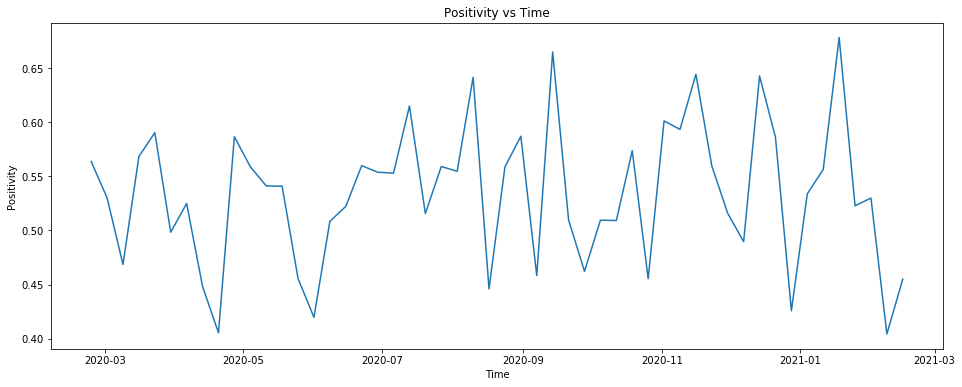

In [100]:
time = average_week_df['timestamp']
positivity = average_week_df['scores']

plt.figure(figsize=(16,6))
plt.plot(time,positivity)
plt.title('Positivity vs Time')
plt.xlabel('Time')
plt.ylabel('Positivity')
plt.show()

### Plot the results against time 

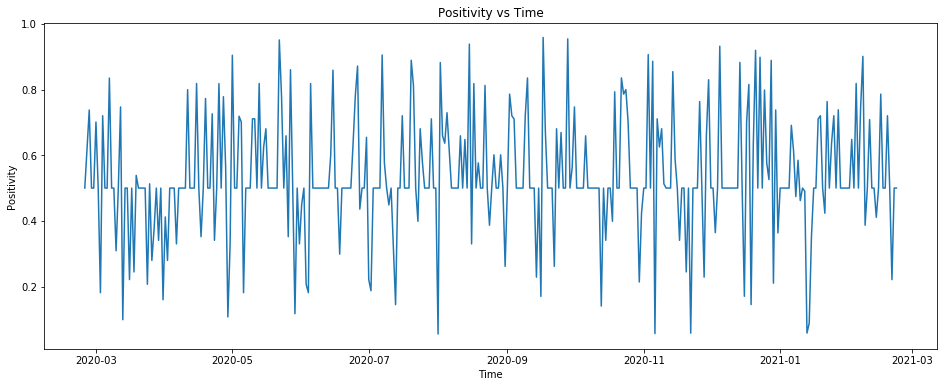

In [55]:
time = df['date_time']
positivity = df['normalised_scores']

plt.figure(figsize=(16,6))
plt.plot(time,positivity)
plt.title('Positivity vs Time')
plt.xlabel('Time')
plt.ylabel('Positivity')
plt.show()

## Topic Modelling

In [17]:
# Scrape the 1,000 top posts for the year
title_1000 = scrape_year_data(reddit,limit=1000)

topic_df = pd.DataFrame.from_dict(title_1000)
topic_df.head()

,title,time
0,"The President’s dog, Síoda, has passed away. R...",1600534772
1,Let's have a cup of tea and let this all blow ...,1610049017
2,Ban Americans traveling until they sort their ...,1594506848
3,The struggle is real: The indignity of trying ...,1594041477
4,Applying for mortgage in a time of gouging ren...,1597765851


In [18]:
topic_df.head()

,title,time
0,"The President’s dog, Síoda, has passed away. R...",1600534772
1,Let's have a cup of tea and let this all blow ...,1610049017
2,Ban Americans traveling until they sort their ...,1594506848
3,The struggle is real: The indignity of trying ...,1594041477
4,Applying for mortgage in a time of gouging ren...,1597765851


### Remove punctuation and lowercase

In [19]:
table = str.maketrans('', '', string.punctuation)

topic_df['title_stripped'] = topic_df['title'].apply(lambda words: "".join([w.translate(table) for w in words]).strip())
topic_df['title_stripped'] = topic_df['title_stripped'].str.lower()
topic_df.head()

,title,time,title_stripped
0,"The President’s dog, Síoda, has passed away. R...",1600534772,the president’s dog síoda has passed away rip ...
1,Let's have a cup of tea and let this all blow ...,1610049017,lets have a cup of tea and let this all blow over
2,Ban Americans traveling until they sort their ...,1594506848,ban americans traveling until they sort their ...
3,The struggle is real: The indignity of trying ...,1594041477,the struggle is real the indignity of trying t...
4,Applying for mortgage in a time of gouging ren...,1597765851,applying for mortgage in a time of gouging rents


### Remove stop Words

In [21]:
topic_df['title_no_stops'] = topic_df['title_stripped'].apply(lambda text:" ".join(remove_stops(text)))

In [22]:
topic_df.head()

,title,time,title_stripped,title_no_stops
0,"The President’s dog, Síoda, has passed away. R...",1600534772,the president’s dog síoda has passed away rip ...,president ’s dog síoda passed away rip síoda
1,Let's have a cup of tea and let this all blow ...,1610049017,lets have a cup of tea and let this all blow over,lets cup tea let blow
2,Ban Americans traveling until they sort their ...,1594506848,ban americans traveling until they sort their ...,ban americans traveling sort shit
3,The struggle is real: The indignity of trying ...,1594041477,the struggle is real the indignity of trying t...,struggle real indignity trying follow american...
4,Applying for mortgage in a time of gouging ren...,1597765851,applying for mortgage in a time of gouging rents,applying mortgage time gouging rents


### Lematize words

In [23]:
topic_df["title_lemmatized"] = topic_df['title_no_stops'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))


In [24]:
topic_df.head()

,title,time,title_stripped,title_no_stops,title_lemmatized
0,"The President’s dog, Síoda, has passed away. R...",1600534772,the president’s dog síoda has passed away rip ...,president ’s dog síoda passed away rip síoda,president 's dog síoda pass away rip síoda
1,Let's have a cup of tea and let this all blow ...,1610049017,lets have a cup of tea and let this all blow over,lets cup tea let blow,let cup tea let blow
2,Ban Americans traveling until they sort their ...,1594506848,ban americans traveling until they sort their ...,ban americans traveling sort shit,ban american travel sort shit
3,The struggle is real: The indignity of trying ...,1594041477,the struggle is real the indignity of trying t...,struggle real indignity trying follow american...,struggle real indignity try follow american re...
4,Applying for mortgage in a time of gouging ren...,1597765851,applying for mortgage in a time of gouging rents,applying mortgage time gouging rents,apply mortgage time gouging rent


In [25]:
count_vectoriser = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [26]:
transform = count_vectoriser.fit_transform(topic_df['title'])

In [27]:
LDA = LatentDirichletAllocation(n_components=6,random_state=42)

In [28]:
LDA.fit(transform)

LatentDirichletAllocation(n_components=6, random_state=42)

In [29]:
irish_set = ['irish','ireland']

for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([count_vectoriser.get_feature_names()[i] for i in topic.argsort()[-12:] if count_vectoriser.get_feature_names()[i] not in irish_set])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['covid', '3rd', 'today', 'man', 'fucking', 'paintings', 'like', 'lock', 'people', 'day']


THE TOP 15 WORDS FOR TOPIC #1
['great', 'morning', 'lockdown', 'ago', 'bit', 'think', 'dog', 'work', 'leo', 'way', 'just', 'lads']


THE TOP 15 WORDS FOR TOPIC #2
['morning', 'news', 'credit', 'country', 'true', 'lads', 'time', 'quarantine', 'painting', 'day']


THE TOP 15 WORDS FOR TOPIC #3
['make', 'think', 'wee', 've', 'yesterday', 'like', '2020', 'years', 'morning', 'dublin']


THE TOP 15 WORDS FOR TOPIC #4
['going', 'just', 'thanks', 'post', 'days', 'old', 'good', '19', 'things', 'covid']


THE TOP 15 WORDS FOR TOPIC #5
['today', 'just', 'times', 'went', 've', 'week', 'thought', 'fair', 'time', 'dublin']




## Named Entity Recognition

In [30]:
entities ={'PERSON':defaultdict(int),
           'NORP':defaultdict(int),
           'FAC':defaultdict(int),
           'ORG':defaultdict(int),
           'GPE':defaultdict(int),
        }

In [31]:
def find_entities(doc):
    if doc.ents:
        for ent in doc.ents:
            try:
                count = entities[ent.label_][ent.text]
                if count >0:
                    entities[ent.label_][ent.text] =count +1
                else:
                    entities[ent.label_][ent.text] =1
                    
            except KeyError:
                pass
                

In [32]:
# obtain all of the entities in from the titles 
for doc in topic_df['title']:
    find_entities(nlp(doc))

In [33]:
popular_entities = defaultdict(list)

In [34]:
for key in entities.keys():
    popular =sorted(entities[key].items(),key=lambda x:x[1],reverse=True)[:5]
    popular_entities[key]=(popular)

In [35]:
popular_entities

defaultdict(list,
            {'PERSON': [('Cork', 5),
              ('Coronavirus', 4),
              ('Joe Biden', 3),
              ('Zoom', 2),
              ('Saw', 2)],
             'NORP': [('Irish', 61),
              ('British', 7),
              ('American', 4),
              ('French', 2),
              ('Beamish', 2)],
             'FAC': [('Donegal Airport', 2),
              ('the French Embassy', 1),
              ('Dublin House', 1),
              ('the Croke Park Massacre', 1),
              ('Gaeltacht', 1)],
             'ORG': [('RTE', 4),
              ('Guinness', 4),
              ('Síoda', 3),
              ('the Irish Times', 3),
              ('Wexford Corporation', 3)],
             'GPE': [('Ireland', 74),
              ('Dublin', 28),
              ('Canada', 3),
              ('Derry', 3),
              ('US', 3)]})

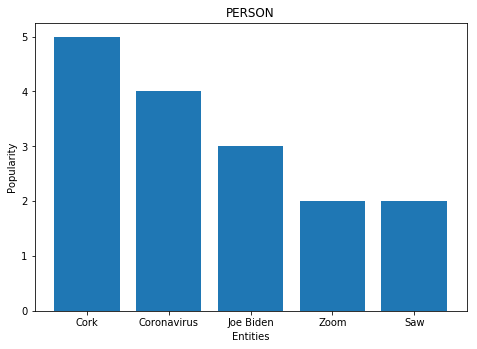

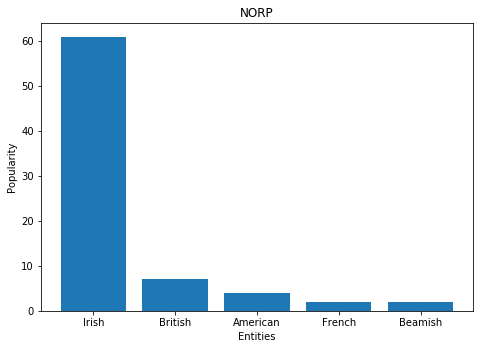

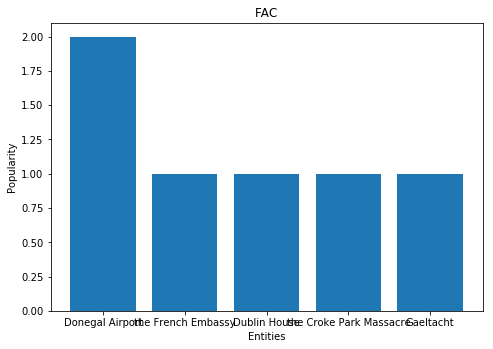

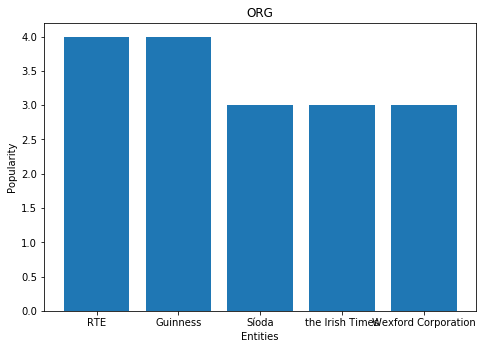

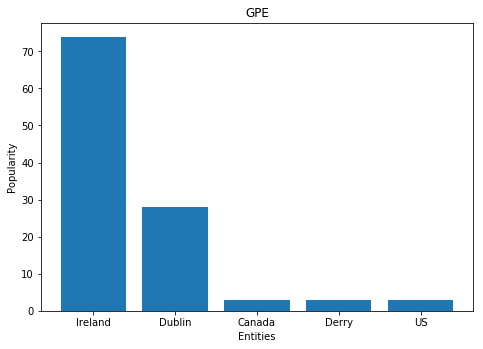

In [36]:
for key in popular_entities.keys():
    
    entity = [x[0] for x in popular_entities[key]]
    count = [x[1] for x in popular_entities[key]]

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(entity,count)
    plt.title(key)
    plt.xlabel('Entities')
    plt.ylabel('Popularity')
    plt.show()

